In [1]:
import numpy as np
import crocoddyl
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler, RobustScaler, Normalizer, StandardScaler
torch.set_default_dtype(torch.double)

if torch.cuda.is_available():
    torch.cuda.empty_cache()

In [2]:
def griddedData(n_points:int = 1500,
                xy_limits:list = [-1.9,1.9],
                theta_limits:list = [-np.pi/2, np.pi/2]
                ):
    size = int(np.sqrt(n_points)) + 1
    min_x, max_x = [*xy_limits]
    xrange = np.linspace(min_x,max_x,size, endpoint=True)
    trange = np.linspace(*theta_limits, size, endpoint=True)
    points = np.array([ [x1,x2, x3] for x1 in xrange for x2 in xrange for x3 in trange])
    np.random.shuffle(points)
    points = points[0:n_points, : ]
    return points

In [3]:
states = griddedData(1000, xy_limits=[-1.9,1.9],theta_limits=[-np.pi/2, np.pi/2])
x = []
y = []
for x0 in tqdm(states):
    model = crocoddyl.ActionModelUnicycle()
    model.costweights = np.array([1., 1.]).T
    problem = crocoddyl.ShootingProblem(x0.T, [model]*30, model)
    ddp = crocoddyl.SolverDDP(problem)
    ddp.solve([], [] , 1000)
    
    xs = np.array(ddp.xs)
    
    # Replace theta by sin theta, cos theta
    sin_x = np.sin(xs[:,2])
    cos_x = np.sin(xs[:,2])
    trajectory = np.hstack((xs[:,0], xs[:,1], sin_x, cos_x)).reshape(31,-1)
    x.append(trajectory[0,:])
    y.append(trajectory[1:,:].flatten())
    
x = np.array(x)
y = np.array(y)

100%|██████████| 1000/1000 [00:01<00:00, 822.47it/s]


In [4]:
normalizer = MinMaxScaler()
y = normalizer.fit_transform(y)


In [5]:
class PolicyNetwork(nn.Module):

        def __init__(self, 
                     input_dims:int  = 4,
                     output_dims:int = 120,
                     fc1_dims:int    = 100,
                     fc2_dims:int    = 20,
                     fc3_dims:int    = 2,
                     activation      = nn.ReLU(),
                     device:str      = 'cpu'
                     ):


                super(PolicyNetwork, self).__init__()
                """Instantiate an untrained neural network with the given params

                Args
                ........
                        
                        1: input_dims   = dimensions of the state space of the robot. 3 for unicycle
                        2: output_dims  = dimensions of the next state
                        3: fc1_dims     = number of units in the first fully connected layer. Default 100
                        4: fc2_dims     = number of units in the second fully connected layer. Default 100
                        5: fc3_dims     = number of units in the third fully connected layer. Default 1
                        6: activation   = activation for the layers, default ReLU.
                        7: device       = device for computations. Generally CPU

                """

                self.input_dims    = input_dims
                self.output_dims   = output_dims
                self.fc1_dims      = fc1_dims
                self.fc2_dims      = fc2_dims
                self.fc3_dims      = fc3_dims

                self.activation    = activation


                #........... Structure
                self.fc1 = nn.Linear(self.input_dims, self.fc1_dims)
                self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)
                self.fc3 = nn.Linear(self.fc2_dims, self.fc3_dims)
                self.fc4 = nn.Linear(self.fc3_dims, self.output_dims)


                #........... Weight Initialization protocol
                nn.init.xavier_uniform_(self.fc1.weight)
                nn.init.xavier_uniform_(self.fc2.weight)
                nn.init.xavier_uniform_(self.fc3.weight)
                nn.init.xavier_uniform_(self.fc4.weight)

                
                #........... Bias Initialization protocol
                nn.init.constant_(self.fc1.bias, 0.003)
                nn.init.constant_(self.fc2.bias, 0.003)
                nn.init.constant_(self.fc3.bias, 0.003)
                nn.init.constant_(self.fc4.bias, 0.003)

                
                # Send the neural net to device
                self.device = torch.device(device)
                self.to(self.device)


                
        def forward(self, state):

                next_state = self.activation(self.fc1(state))
                next_state = self.activation(self.fc2(next_state))
                next_state = self.activation(self.fc3(next_state))
                next_state = self.fc4(next_state)
                
                return next_state
            

BATCHSIZE     = 128
lr            = 1e-2
DECAY         = 5e-4

DEVICE        = 'cpu'
net = PolicyNetwork()

In [6]:
x, y = shuffle(x, y, random_state=0)

xtest = torch.Tensor(x[0:10, :])
ytest = y[0:10, :]

xtrain = torch.Tensor(x[1:,:])
ytrain = torch.Tensor(y[1:,:])

dataset = torch.utils.data.TensorDataset(xtrain, ytrain)
dataloader = torch.utils.data.DataLoader(dataset, batch_size = BATCHSIZE, shuffle=True)

#......  CRITERIA
criterion1 = torch.nn.MSELoss(reduction='sum')
criterion2 = torch.nn.L1Loss(reduction='mean')

opt = torch.optim.Adam(net.parameters(), lr = lr, betas=[0.5, 0.9], weight_decay=DECAY)
#opt = torch.optim.ASGD(net.parameters(), lr = lr, weight_decay=DECAY)
#opt = torch.optim.LBFGS(net.parameters(), history_size=10, max_iter=4)

net.to(DEVICE)
xtest.to(DEVICE)
for epoch in range(100):
    for data, target in dataloader:
        net.train()
        opt.zero_grad()

        data        = data.to(DEVICE)
        target      = target.to(DEVICE)
        output      = net(data)
         
           
        
        loss        = torch.sqrt(criterion1(output, target)) 
        loss.backward()
              
        opt.step()
        

    
    # Validation
    acc = 0
    acc2 = 0
    pred = net(xtest).detach().numpy()
    mae = np.mean(np.abs(pred - ytest))
    
    for i in range(len(xtest)):
        xtest[i].resize_(1, 3)
        pred = net(xtest[i]).detach().numpy()
        
        if np.mean(np.abs(pred - ytest[i])) < 0.01:
            acc += 1
        elif np.mean(np.abs(pred - ytest[i])) < 0.1:
            acc2 += 1
    print(f"EPOCH : {epoch} || MAE : {mae} || Within 0.01: {acc}/{len(xtest)} || Within 0.1 : {acc2}/{len(xtest)}")
    

EPOCH : 0 || MAE : 0.3343547071010506 || Within 0.01: 0/10 || Within 0.1 : 0/10
EPOCH : 1 || MAE : 0.213859530412173 || Within 0.01: 0/10 || Within 0.1 : 0/10
EPOCH : 2 || MAE : 0.175343806735261 || Within 0.01: 0/10 || Within 0.1 : 3/10
EPOCH : 3 || MAE : 0.17357960227761676 || Within 0.01: 0/10 || Within 0.1 : 2/10
EPOCH : 4 || MAE : 0.1721891190913252 || Within 0.01: 0/10 || Within 0.1 : 3/10
EPOCH : 5 || MAE : 0.17099097519932546 || Within 0.01: 0/10 || Within 0.1 : 3/10
EPOCH : 6 || MAE : 0.172614728417953 || Within 0.01: 0/10 || Within 0.1 : 3/10
EPOCH : 7 || MAE : 0.17083385175717833 || Within 0.01: 0/10 || Within 0.1 : 3/10
EPOCH : 8 || MAE : 0.1774106388144279 || Within 0.01: 0/10 || Within 0.1 : 2/10
EPOCH : 9 || MAE : 0.17113226583873006 || Within 0.01: 0/10 || Within 0.1 : 3/10
EPOCH : 10 || MAE : 0.17373601932928692 || Within 0.01: 0/10 || Within 0.1 : 3/10
EPOCH : 11 || MAE : 0.17524416605377724 || Within 0.01: 0/10 || Within 0.1 : 3/10
EPOCH : 12 || MAE : 0.1737608020288

(-1.5, 1.5)

<Figure size 432x288 with 0 Axes>

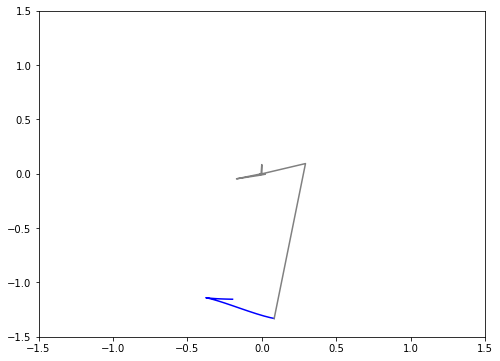

In [11]:
x0  = np.array([np.random.uniform(-1.5,1.5), np.random.uniform(-1.5,1.5), np.random.uniform(-1.5,1.5)])
model               = crocoddyl.ActionModelUnicycle()
model.costWeights   = np.array([1.,1.]).T
problem             = crocoddyl.ShootingProblem(x0.T, [model]*30, model)
ddp                 = crocoddyl.SolverDDP(problem)
log                 = crocoddyl.CallbackLogger()
ddp.setCallbacks([log])
ddp.solve([], [], 1000)
stops = log.stops[1:]
xs = np.array(ddp.xs)

x0 = x0.reshape(1, 3)

x = x0[:,0]
y = x0[:,1]
sinx, cosx = np.sin(x0[:,-1]), np.cos(x0[:,-1])
x_test = torch.tensor([x, y, sinx, cosx]).reshape(1, 4)

prediction = net(x_test).detach().numpy()
prediction = normalizer.inverse_transform(prediction)
prediction = prediction.reshape(30, 4)
guess = []
guess.append([x0[:,0].item(), x0[:,1].item(), x0[:,2].item()])
for state in prediction:
    x = state[0]
    y = state[1]
    theta = np.arctan2(state[2], state[3])
    next_state = [x, y, theta]
    guess.append(next_state)


guess = np.array(guess)

plt.clf()
fig, axs = plt.subplots(1, figsize=(8,6))
axs.plot(xs[:,0], xs[:,1], c = 'blue', label= " Crocoddyl")

axs.plot(guess[:,0], guess[:,1], c = 'grey', label= " Guess")
axs.set_xlim([-1.5,1.5 ])
axs.set_ylim([-1.5,1.5 ])